In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pettingzoo.classic import chess_v6
from collections import deque
import random
import numpy as np

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(111, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 1024)
        self.fc2 = nn.Linear(1024, 4672)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.reshape(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# DQN Agent
class DQNAgent:
    def __init__(self, episodes):
        self.policy_net = DQN().to(device)
        self.target_net = DQN().to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=1e-4)
        self.memory = deque(maxlen=10000)
        self.batch_size = 32
        self.gamma = 0.99
        self.epsilon=1
        self.episodes=episodes
        self.decay_factor=0.01 ** (1 / self.episodes)

    def remember(self, state, action, next_state, reward, done):
        self.memory.append((state, action, next_state, reward, done))
    def act(self, state, mask):
        sample = random.random()
        mask_tensor = torch.tensor(mask, dtype=torch.float32).to(device)

        if sample > self.epsilon:
            with torch.no_grad():
                state = state.to(device)
                action_values = self.policy_net(state)
                masked_action_values = action_values + (1 - mask_tensor) * -1e10
                return masked_action_values.max(1)[1].view(1, 1)
        else:

            legal_actions = [i for i, legal in enumerate(mask) if legal == 1]
            if not legal_actions:
                print("No legal actions available. Handling special case.")
                return torch.tensor([[0]], device=device, dtype=torch.long)

            return torch.tensor([[random.choice(legal_actions)]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        transitions = random.sample(self.memory, self.batch_size)
        batch = list(zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch[2])), dtype=torch.bool)
        if non_final_mask.any():
            non_final_next_states = torch.cat([s for s in batch[2] if s is not None])
        else:
            non_final_next_states = torch.tensor([], dtype=torch.float32, device=device)

        state_batch = torch.cat(batch[0])
        action_batch = torch.cat(batch[1])
        reward_batch = torch.cat(batch[3])

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        next_state_values = torch.zeros(self.batch_size, device=device)
        if non_final_mask.any():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch

        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()


    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


def get_state(observation):
    board_state = observation['observation']
    if np.any(np.array(board_state.strides) < 0):
        board_state = board_state.copy()
    board_state_tensor = torch.tensor(board_state, dtype=torch.float32).to(device).unsqueeze(0).permute(0, 3, 1, 2)
    return board_state_tensor


def extract_tensors(experiences):
    batch = list(zip(*experiences))

    t1 = torch.cat(batch[0])
    t2 = torch.cat(batch[1])
    t3 = [s for s in batch[2] if s is not None]
    if t3:
        t3 = torch.cat(t3)
    t4 = torch.cat(batch[3])
    t5 = torch.tensor(batch[4], dtype=torch.uint8)

    return (t1, t2, t3, t4, t5)



Episode 0 completed. Epsilon: 1. Total Reward: 0. Step Count: 323
Episode 1 completed. Epsilon: 0.9908319448927676. Total Reward: 0. Step Count: 346
Episode 2 completed. Epsilon: 0.9817479430199845. Total Reward: 0. Step Count: 349
Episode 3 completed. Epsilon: 0.9727472237769652. Total Reward: 0. Step Count: 140
Episode 4 completed. Epsilon: 0.9638290236239707. Total Reward: 0. Step Count: 476
Episode 5 completed. Epsilon: 0.9549925860214361. Total Reward: 0. Step Count: 312
Episode 6 completed. Epsilon: 0.9462371613657932. Total Reward: 0. Step Count: 320
Episode 7 completed. Epsilon: 0.9375620069258804. Total Reward: 0. Step Count: 151
Episode 8 completed. Epsilon: 0.9289663867799366. Total Reward: 0. Step Count: 298
Episode 9 completed. Epsilon: 0.9204495717531715. Total Reward: 0. Step Count: 231
Episode 10 completed. Epsilon: 0.91201083935591. Total Reward: 0. Step Count: 416
Episode 11 completed. Epsilon: 0.9036494737223018. Total Reward: 0. Step Count: 341
Episode 12 completed.

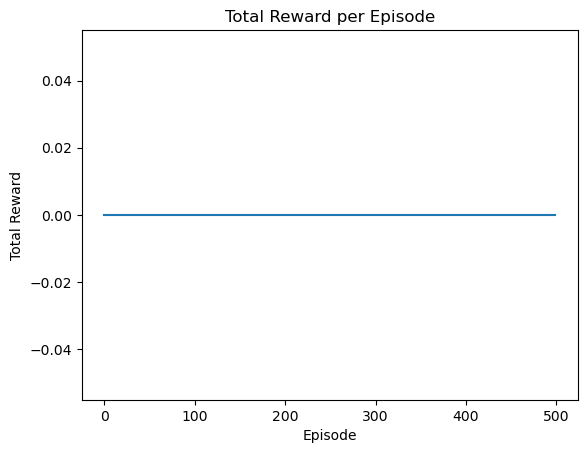

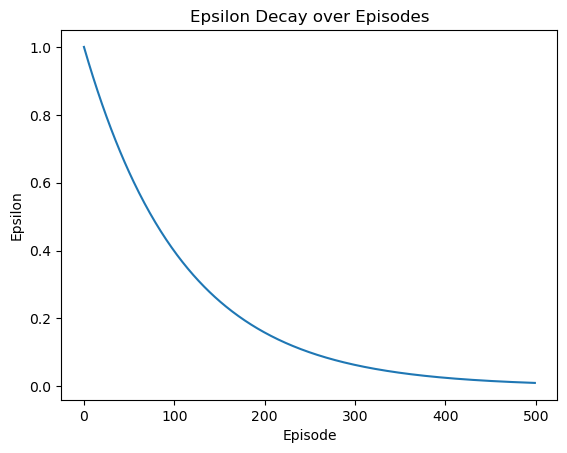

Training completed


In [ ]:
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = chess_v6.env()
agent = DQNAgent(episodes=500)
rewards_per_episode=[]
epsilon_values=[]
for i_episode in range(agent.episodes):
    env.reset()
    total_reward=0
    step_count=0
    for agent_id in env.agent_iter():
        observation, reward, terminated, truncated, info = env.last()
        total_reward=total_reward+reward
        step_count=step_count+1
        done=terminated or truncated
        state = get_state(observation)
        mask = observation["action_mask"]

        if not done:
            action = agent.act(state, mask)
            env.step(action.item())
            next_observation, reward, terminated,truncated,  _ = env.last()
            done=terminated or truncated
            next_state = get_state(next_observation) if not done else None
            reward = torch.tensor([reward], device=device)

            agent.remember(state, action, next_state, reward, done)
        else:
            env.step(None)


        agent.optimize_model()
    rewards_per_episode.append(total_reward)
    epsilon_values.append(agent.epsilon)
    print(f"Episode {i_episode} completed. Epsilon: {agent.epsilon}. Total Reward: {total_reward}. Step Count: {step_count}")
    agent.epsilon=max(agent.epsilon*agent.decay_factor, 0.01)
    if i_episode % 10 == 0:
        agent.update_target_net()

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

plt.figure()
plt.plot(epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay over Episodes')
plt.show()
print("Training completed")


In [ ]:
torch.save(agent.policy_net.state_dict(), 'vduggemp_vkaturu_pvajha_rlproject_policy_net.pth')

In [ ]:
torch.save(agent.target_net.state_dict(), 'vduggemp_vkaturu_pvajha_rlproject_target_net.pth')

Episode 0: Total Reward for Agent 2: 0
Episode 1: Total Reward for Agent 2: 0
Episode 2: Total Reward for Agent 2: 0
Episode 3: Total Reward for Agent 2: 0
Episode 4: Total Reward for Agent 2: 0
Episode 5: Total Reward for Agent 2: 0
Episode 6: Total Reward for Agent 2: 0
Episode 7: Total Reward for Agent 2: 0
Episode 8: Total Reward for Agent 2: 0
Episode 9: Total Reward for Agent 2: 0
Average Reward for Agent 2: 0.0


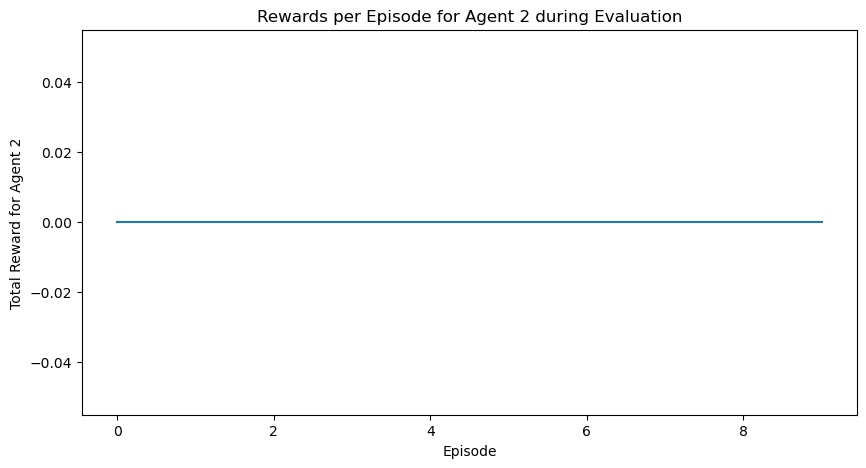

In [ ]:
import matplotlib.pyplot as plt

def evaluate_agent(agent, env, num_episodes=10):
    agent_2_rewards = []  # List to store the total rewards for agent 2 in each episode
    for i_episode in range(num_episodes):
        env.reset()
        total_reward_agent_2 = 0  # Reset Agent 2's reward at the start of each episode
        for agent_id in env.agent_iter():
            observation, reward, terminated, truncated, _ = env.last()

            if terminated or truncated:
                env.step(None)
                break
            else:
                state = get_state(observation)
                mask = observation["action_mask"]

                if agent_id.endswith('1'):  # agent 1 takes random actions
                    legal_actions = [i for i, legal in enumerate(mask) if legal == 1]
                    action = torch.tensor([[random.choice(legal_actions)]], device=device, dtype=torch.long) if legal_actions else torch.tensor([[0]], device=device, dtype=torch.long)
                else:  # agent 2 takes greedy actions based on the trained model
                    action = agent.act(state, mask)
                    total_reward_agent_2 += reward  # Accumulate rewards for Agent 2

                env.step(action.item())

        agent_2_rewards.append(total_reward_agent_2)
        print(f"Episode {i_episode}: Total Reward for Agent 2: {total_reward_agent_2}")

    avg_reward_agent_2 = sum(agent_2_rewards) / len(agent_2_rewards)
    print(f"Average Reward for Agent 2: {avg_reward_agent_2}")
    plt.figure(figsize=(10, 5))
    plt.plot(agent_2_rewards)
    plt.title('Rewards per Episode for Agent 2 during Evaluation')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward for Agent 2')
    plt.show()

    return avg_reward_agent_2

# Evaluate and get the average reward for Agent 2
avg_reward_agent_2 = evaluate_agent(agent, env, num_episodes=10)


Episode 0: Total Reward: 0
Episode 1: Total Reward: 0
Episode 2: Total Reward: 0
Episode 3: Total Reward: 0
Episode 4: Total Reward: -1
Episode 5: Total Reward: -1
Episode 6: Total Reward: -1
Episode 7: Total Reward: 0
Episode 8: Total Reward: -1
Episode 9: Total Reward: 0
Average Reward: -0.4


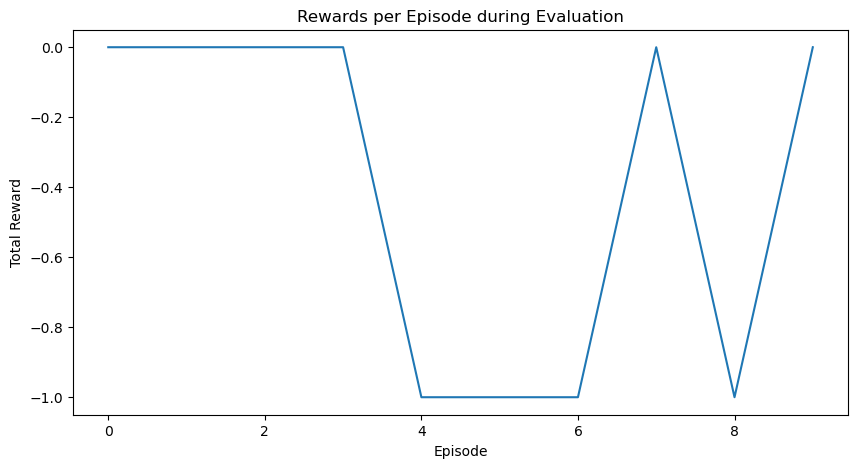

In [ ]:
import matplotlib.pyplot as plt

def evaluate_agent(agent, env, num_episodes=10):
    total_rewards = []
    for i_episode in range(num_episodes):
        env.reset()
        total_reward = 0
        for agent_id in env.agent_iter():
            observation, reward, terminated, truncated, _ = env.last()
            total_reward += reward

            if terminated or truncated:
                env.step(None)
                break
            else:
                state = get_state(observation)
                mask = observation["action_mask"]

                if agent_id.endswith('1'):  # agent 1 takes random actions
                    legal_actions = [i for i, legal in enumerate(mask) if legal == 1]
                    action = torch.tensor([[random.choice(legal_actions)]], device=device, dtype=torch.long) if legal_actions else torch.tensor([[0]], device=device, dtype=torch.long)
                else:  # agent 2 takes greedy actions based on the trained model
                    action = agent.act(state, mask)

                env.step(action.item())

        total_rewards.append(total_reward)
        print(f"Episode {i_episode}: Total Reward: {total_reward}")

    avg_reward = sum(total_rewards) / len(total_rewards)
    print(f"Average Reward: {avg_reward}")
    plt.figure(figsize=(10, 5))
    plt.plot(total_rewards)
    plt.title('Rewards per Episode during Evaluation')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

    return avg_reward


avg_reward = evaluate_agent(agent, env, num_episodes=10)


## Monte Carlo Tree Search (MCTS)

In [ ]:
import numpy as np
from pettingzoo.classic import chess_v6

class MCTSNode:
    def __init__(self, observation, reward, done, info, parent=None, action=None):
        self.observation = observation
        self.reward = reward
        self.done = done
        self.info = info
        self.parent = parent
        self.action = action
        self.children = []
        self.wins = 0
        self.visits = 0
        self.untried_actions = self.get_legal_actions()

    def get_legal_actions(self):
        # Extracts indices of legal actions from the current observation's action_mask
        return np.flatnonzero(self.observation['action_mask'])

    def is_terminal_node(self):
        return self.done

    def select_child(self):
        from math import log, sqrt
        if self.visits == 0:
            return None
        log_parent_visits = log(self.visits)
        return max(self.children, key=lambda child: (child.wins / child.visits) + sqrt(2 * log_parent_visits / child.visits) if child.visits > 0 else 0)

    def add_child(self, action, observation, reward, done, info):
        child_node = MCTSNode(observation, reward, done, info, self, action)
        self.children.append(child_node)
        self.untried_actions = np.delete(self.untried_actions, np.where(self.untried_actions == action))
        return child_node

    def update(self, result):
        self.visits += 1
        self.wins += result

In [ ]:
def mcts(root, env, iterations=100):
    for i in range(iterations):
        node = root
        while node.children:
            child = node.select_child()
            if child:
                node = child
            else:
                break
        if not node.is_terminal_node() and node.untried_actions.size > 0:
            action = np.random.choice(node.untried_actions)
            if action in node.get_legal_actions():  # Double-checking action legality before execution
                env.step(action)
                observation, reward, done, truncation, info = env.last()
                if done or truncation:
                    print(f"Action led to game end: {action}")
                    break
                node = node.add_child(action, observation, reward, done or truncation, info)
        result = reward  # The reward at the end of simulation (placeholder, should implement actual game logic)
        while node:
            node.update(result)
            node = node.parent

In [ ]:
import numpy as np
from pettingzoo.classic import chess_v6
def play_game():
    env = chess_v6.env(render_mode="human")
    env.reset()
    for agent in env.agent_iter():
        observation, reward, done, truncation, info = env.last()
        if done or truncation:
            env.step(None)  # If the game is over, send None as required
        else:
            legal_moves = np.flatnonzero(observation['action_mask'])  # Get all legal moves
            if legal_moves.size > 0:
                action = np.random.choice(legal_moves)  # Choose a legal action
                env.step(action)  # Execute the chosen legal action
            else:
                print("No legal moves available; passing the turn.")
                env.step(None)

        if done:  # Check again if the game has ended
            print("Game over due to a terminal state. Final result:", "Draw" if reward == 0 else "Win" if reward == 1 else "Loss")
            break  # Exit the loop if the game is over

play_game()


Game over due to a terminal state. Final result: Draw


MCTS and DQN

In [ ]:
class MCTSNode:
    def __init__(self, observation, reward, done, info, parent=None, action=None):
        self.observation = observation
        self.reward = reward
        self.done = done
        self.info = info
        self.parent = parent
        self.action = action
        self.children = []
        self.wins = 0
        self.visits = 0
        self.untried_actions = self.get_legal_actions()

    def get_legal_actions(self):
        return np.flatnonzero(self.observation['action_mask'])

    def is_terminal_node(self):
        return self.done

    def select_child(self):
        from math import log, sqrt
        if self.visits == 0:
            return None
        log_parent_visits = log(self.visits)
        return max(self.children, key=lambda child: (child.wins / child.visits) + sqrt(2 * log_parent_visits / child.visits) if child.visits > 0 else 0)

    def add_child(self, action, observation, reward, done, info):
        child_node = MCTSNode(observation, reward, done, info, self, action)
        self.children.append(child_node)
        self.untried_actions = np.delete(self.untried_actions, np.where(self.untried_actions == action))
        return child_node

    def update(self, result):
        self.visits += 1
        self.wins += result

def mcts(root, env, iterations=100):
    for i in range(iterations):
        node = root
        while node.children:
            child = node.select_child()
            if child:
                node = child
            else:
                break
        if not node.is_terminal_node() and node.untried_actions.size > 0:
            action = np.random.choice(node.untried_actions)
            if action in node.get_legal_actions():
                env.step(action)
                observation, reward, done, truncation, info = env.last()
                if done or truncation:
                    print(f"Action led to game end: {action}")
                    break
                node = node.add_child(action, observation, reward, done or truncation, info)
        result = reward
        while node:
            node.update(result)
            node = node.parent


In [ ]:
def play_game_with_agents(dqn_agent, mcts_iterations=100):
    env = chess_v6.env(render_mode="human")
    env.reset()
    for agent in env.agent_iter():
        observation, reward, done, truncation, info = env.last()
        if done or truncation:
            env.step(None)
        else:
            if agent == "player_0":
                state = get_state(observation)  # Ensure observation is correctly formatted
                mask = observation['action_mask']  # Ensure 'action_mask' is correctly accessed
                action = dqn_agent.act(state, mask)
                env.step(action.item())
            else:
                root = MCTSNode(observation, reward, done, info)
                mcts(root, env, iterations=mcts_iterations)
        if done:
            print("Game over due to a terminal state. Final result:", "Draw" if reward == 0 else "Win" if reward == 1 else "Loss")
            break

mcts_iterations = 1000
play_game_with_agents(agent, mcts_iterations)

Action led to game end: 1999
Game over due to a terminal state. Final result: Loss
